In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
movenet = hub.load("https://tfhub.dev/google/movenet/multipose/lightning/1")
movenet = movenet.signatures['serving_default']

In [ ]:
keypoint_names = [
    'nose',  # 0
    'left_eye',  # 1
    'right_eye', # 2
    'left_ear', # 3
    'right_ear', # 4
    'left_shoulder', # 5 
    'right_shoulder', # 6
    'left_elbow', # 7
    'right_elbow', # 8
    'left_wrist', # 9
    'right_wrist', # 10
    'left_hip', # 11
    'right_hip', # 12
    'left_knee', # 13
    'right_knee', # 14
    'left_ankle', # 15
    'right_ankle' # 16
    ]

keypoints_to_detect = [
    5, # left shoulder
    7, # left elbow
    9, # left wrist
    13, # left knee
    15, # left ankle
]

In [ ]:
def get_keypoints(img) :
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 256, 256)
    input_img = tf.cast(img, dtype=tf.int32)
    results = movenet(input_img)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
    return keypoints_with_scores

def draw_connections(frame, keypoints, confidence_threshold):
    edges = {
        (0, 1): 'm',
        (0, 2): 'c',
        (1, 3): 'm',
        (2, 4): 'c',
        (0, 5): 'm',
        (0, 6): 'c',
        (5, 7): 'm',
        (7, 9): 'm',
        (6, 8): 'c',
        (8, 10): 'c',
        (5, 6): 'y',
        (5, 11): 'm',
        (6, 12): 'c',
        (11, 12): 'y',
        (11, 13): 'm',
        (13, 15): 'm',
        (12, 14): 'c',
        (14, 16): 'c'
    }
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 1)

def draw_keypoints(frame, keypoints, confidence_threshold, keypoints_to_detect=keypoints_to_detect):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in keypoints_to_detect:
        ky, kx, kp_conf = shaped[kp]
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 1, (0,0,255), -1)

    # for kp in shaped:
    #     ky, kx, kp_conf = kp
    #     if kp_conf > confidence_threshold:
    #         cv2.circle(frame, (int(kx), int(ky)), 1, (0,255,0), -1)

def loop_through_people(frame, keypoints_with_scores, confidence_threshold):
    for person in keypoints_with_scores[:2]:
        draw_keypoints(frame, person, confidence_threshold)
        # draw_connections(frame, person, confidence_threshold)

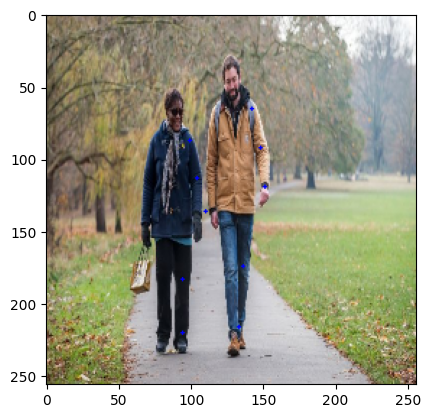

In [ ]:
img = cv2.imread('testing_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
keypoints_with_score = get_keypoints(img)
loop_through_people(img, keypoints_with_score, 0.3)
plt.imshow(img)


In [6]:

def get_keypoints_from_video(video_path, confidence_threshold):
    # from camera
    # cap = cv2.VideoCapture(0)
    cap = cv2.VideoCapture(video_path)
    i = 0
    scale = 1
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        i += 1
        if not ret:
            break
        if i % 1 == 0:
            frame = frame[:, :, ::-1]
            frame = cv2.resize(frame, (256*scale, 256*scale))
            keypoints_with_scores = get_keypoints(frame)
            loop_through_people(frame, keypoints_with_scores, confidence_threshold)
    #         frames.append(frame)
    # return frames
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [84]:
get_keypoints_from_video('dataset/SMVDU-Single-Gait/01_5_SG.MOV', 0.1)
# frames = get_keypoints_from_video('dataset/SMVDU-Multi-Gait/01_02_3_MG.MOV', 0.2)

In [7]:
def get_main_keypoints(frame, keypoints, confidence_threshold, keypoints_to_detect=keypoints_to_detect):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    keypoints_coordinates = {}
    for kp in keypoints_to_detect:
        ky, kx, kp_conf = shaped[kp]
        if kp_conf > confidence_threshold:
            keypoints_coordinates[keypoint_names[kp]] = (int(kx), int(ky))
    # print(keypoints_coordinates)
    return keypoints_coordinates

def loop_through_people_main_keypoints(frame, keypoints_with_scores, confidence_threshold):
    person_main_keypoints = []
    for person in keypoints_with_scores[:1]:
        person_main_keypoints.append(get_main_keypoints(frame, person, confidence_threshold))
    return person_main_keypoints

def get_main_keypoints_from_video(video_path, confidence_threshold):
    cap = cv2.VideoCapture(video_path)
    # start video from 1 second 
    # cap.set(cv2.CAP_PROP_POS_MSEC, 1000)
    i = 0
    scale = 1
    person_main_keypoints_sequence = {}
    while cap.isOpened():
        ret, frame = cap.read()
        i += 1
        if not ret:
            break
        if i % 1 == 0:
            frame = frame[:, :, ::-1]
            frame = cv2.resize(frame, (256*scale, 256*scale))
            keypoints_with_scores = get_keypoints(frame)
            person_main_keypoints = loop_through_people_main_keypoints(frame, keypoints_with_scores, confidence_threshold)
            for person, pmkp in enumerate(person_main_keypoints):
                if person not in person_main_keypoints_sequence:
                    person_main_keypoints_sequence[person] = {}
                for keypoint, coordinates in pmkp.items():
                    if keypoint not in person_main_keypoints_sequence[person]:
                        person_main_keypoints_sequence[person][keypoint] = []
                    # coordinates = (coordinates[0]/256.0, coordinates[1]/256.0)
                    person_main_keypoints_sequence[person][keypoint].append(coordinates)
    #         
    cap.release()
    cv2.destroyAllWindows()
    return person_main_keypoints_sequence

In [109]:
person_main_keypoints_sequence = get_main_keypoints_from_video('dataset/SMVDU-Single-Gait/01_1_SG.MOV', 0)

In [114]:
len(person_main_keypoints_sequence[0]['left_shoulder'])

426

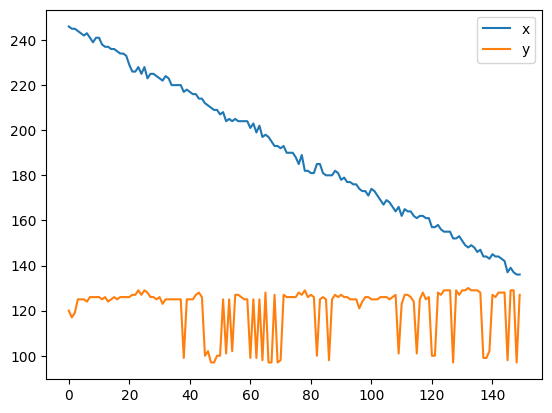

In [116]:
plt.plot(person_main_keypoints_sequence[0]['left_wrist'][150:300])
plt.legend(['x', 'y'])

In [8]:
dataset_folder = 'dataset/SMVDU-Single-Gait'
import os
import pickle

for video in os.listdir(dataset_folder):
    x = video.split('_')
    # if x[1][0] == '1' : 
    video_path = os.path.join(dataset_folder, video)
    person_main_keypoints_sequence = get_main_keypoints_from_video(video_path, 0)
    model_inp_matrix = []
    for mkp in keypoints_to_detect :
        x = person_main_keypoints_sequence[0][keypoint_names[mkp]]
        model_inp_matrix.append(x)
    model_inp_matrix = np.array(model_inp_matrix)
    model_inp_matrix = model_inp_matrix[:, 150:300]
    model_inp_matrix = np.reshape(model_inp_matrix, (model_inp_matrix.shape[0], model_inp_matrix.shape[1], 2))
    with open('numpy_dataset/' + video + '.pkl', 'wb') as f:
        pickle.dump(model_inp_matrix, f)
    
    # elif x[1][0] == '2' :
        